In [251]:
import pandas as pd
import numpy as np
import altair as alt
import requests
from bs4 import BeautifulSoup
import json
from sklearn.model_selection import train_test_split
from scipy.integrate import quad
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

In [2]:
from true_skill_through_time import *

In [6]:
games = pd.read_parquet("data/boxing_matches_refined_tstt.parquet")

In [7]:
games.head()

,winner,loser,timestamp
0,Jake Kilrain,Jack Daley,1879-01-01
1,Jake Kilrain,Jem Driscoll,1879-02-01
2,Jake Kilrain,Dan Dwyer,1879-03-10
3,John L. Sullivan,Jack Curley,1879-03-13
4,John L. Sullivan,Johnny Cocky Woods,1879-03-14


In [8]:
total_matches_df = games.winner.value_counts().add(games.loser.value_counts(), fill_value=0).sort_values()

In [11]:
total_matches_df.describe()

count    16033.000000
mean         3.199775
std         11.276392
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        280.000000
Name: count, dtype: float64

In [9]:
players_ge_40_matches_df = total_matches_df[total_matches_df>=40.0]

In [13]:
len(players_ge_40_matches_df)

303

In [10]:
players_ge_40_matches_df = pd.DataFrame(players_ge_40_matches_df, columns=['count']).reset_index()

In [11]:
players_ge_40_matches_df = players_ge_40_matches_df.rename(columns={'index': 'fighter'})

In [30]:
players_ge_40_matches_df.to_csv("data/players_ge_40_matches.csv", index=False)

In [33]:
len(players_ge_40_matches_df), players_ge_40_matches_df.fighter.nunique()

(303, 303)

In [12]:
players_ge_40_matches_lst = players_ge_40_matches_df.fighter.unique().tolist()

In [17]:
with open("data/players_ge_40_matches_lst.json", "w") as f:
    json.dump(players_ge_40_matches_lst, f, indent=4)

In [13]:
games_ge_40 = games[games.winner.isin(players_ge_40_matches_lst) | games.loser.isin(players_ge_40_matches_lst)]

In [18]:
len(games), len(games_ge_40)

(25651, 20711)

In [51]:
games.head()

,winner,loser,timestamp
0,Jake Kilrain,Jack Daley,1879-01-01
1,Jake Kilrain,Jem Driscoll,1879-02-01
2,Jake Kilrain,Dan Dwyer,1879-03-10
3,John L. Sullivan,Jack Curley,1879-03-13
4,John L. Sullivan,Johnny Cocky Woods,1879-03-14


In [50]:
games_ge_40.head()

,index,winner,loser,timestamp
0,3,John L. Sullivan,Jack Curley,1879-03-13
1,4,John L. Sullivan,Johnny Cocky Woods,1879-03-14
2,6,John L. Sullivan,George Rooke,1879-06-28
3,7,John L. Sullivan,Dan Dwyer,1879-06-28
4,9,John L. Sullivan,Professor John Donaldson,1880-12-24


In [48]:
games_ge_40 = games_ge_40.reset_index()

In [34]:
#games_ge_40.groupby(['winner', 'timestamp']).size().reset_index(name='count').sort_values(['winner', 'timestamp'])
len(games_ge_40)

20711

In [119]:
games_ge_40.to_csv("data/games_ge_40.csv", index=False)

In [120]:
games_ge_40 = games_ge_40.rename(columns={'index': 'game_index'})

### train test split (80:20) based on time for each one of 303 players who has played at least 40 matches

In [121]:
winners = games_ge_40[['winner', 'timestamp', 'game_index']].copy()
winners['result'] = 1
winners = winners.rename(columns={'winner': 'player'})

# Create a dataframe for losers
losers = games_ge_40[['loser', 'timestamp', 'game_index']].copy()
losers['result'] = 0
losers = losers.rename(columns={'loser': 'player'})

# Concatenate winners and losers dataframes
result_df = pd.concat([winners, losers], ignore_index=True)

# Sort the resulting dataframe by timestamp
result_df = result_df.sort_values(['player', 'timestamp']).reset_index(drop=True)

In [122]:
len(result_df)

41422

In [123]:
players_ge_40_matches_df = result_df[result_df.player.isin(players_ge_40_matches_lst)].reset_index().iloc[:, 1:]

In [124]:
players_ge_40_matches_df.head()

,player,timestamp,game_index,result
0,Aaron Pryor,1976-11-12,11968,1
1,Aaron Pryor,1977-02-01,12009,1
2,Aaron Pryor,1977-02-24,12031,1
3,Aaron Pryor,1977-03-12,12044,1
4,Aaron Pryor,1977-03-26,12055,1


In [125]:
len(players_ge_40_matches_df)

21333

In [126]:
player_data = players_ge_40_matches_df[players_ge_40_matches_df['player'] == 'Aaron Pryor'].sort_values('timestamp')
player_train, player_test = train_test_split(player_data, test_size=0.2, shuffle=False)

In [127]:
player_train

,player,timestamp,game_index,result
0,Aaron Pryor,1976-11-12,11968,1
1,Aaron Pryor,1977-02-01,12009,1
2,Aaron Pryor,1977-02-24,12031,1
3,Aaron Pryor,1977-03-12,12044,1
4,Aaron Pryor,1977-03-26,12055,1
5,Aaron Pryor,1977-05-07,12073,1
6,Aaron Pryor,1977-09-03,12155,1
7,Aaron Pryor,1977-10-07,12185,1
8,Aaron Pryor,1977-11-11,12211,1
9,Aaron Pryor,1978-01-16,12246,1


In [128]:
player_test

,player,timestamp,game_index,result
32,Aaron Pryor,1983-04-02,13506,1
33,Aaron Pryor,1983-09-09,13595,1
34,Aaron Pryor,1984-06-22,13747,1
35,Aaron Pryor,1985-03-02,13878,1
36,Aaron Pryor,1987-08-08,14434,0
37,Aaron Pryor,1988-12-15,14743,1
38,Aaron Pryor,1990-05-16,15148,1
39,Aaron Pryor,1990-12-04,15293,1


In [129]:
test_size = 0.2
train_data = []
test_data = []

for player in players_ge_40_matches_df['player'].unique():
    player_data = players_ge_40_matches_df[players_ge_40_matches_df['player'] == player].sort_values('timestamp')
    
    # Ensure we have enough data to split
    if len(player_data) > 1:
        player_train, player_test = train_test_split(player_data, test_size=test_size, shuffle=False)
        train_data.append(player_train)
        test_data.append(player_test)
    else:
        print(f'player %s has only one match'%(player))
        # If only one match, add it to training data
        train_data.append(player_data)



In [130]:
train_df = pd.concat(train_data, ignore_index=True)
test_df = pd.concat(test_data, ignore_index=True)

In [131]:
len(train_df), len(test_df), len(games_ge_40)

(16946, 4387, 20711)

In [146]:
train_df[train_df.player=='Abe Attell']

,player,timestamp,game_index,result
32,Abe Attell,1900-12-20,563,1
33,Abe Attell,1901-01-26,567,1
34,Abe Attell,1901-02-15,569,1
35,Abe Attell,1901-03-01,572,1
36,Abe Attell,1901-03-08,573,1
...,...,...,...,...
128,Abe Attell,1910-08-22,1088,1
129,Abe Attell,1910-09-05,1089,1
130,Abe Attell,1910-09-16,1091,1
131,Abe Attell,1910-10-07,1092,1


In [147]:
test_df[test_df.player=='Abe Attell']

,player,timestamp,game_index,result
8,Abe Attell,1910-10-27,1097,1
9,Abe Attell,1910-10-28,1098,1
10,Abe Attell,1910-11-30,1104,1
11,Abe Attell,1911-01-09,1113,1
12,Abe Attell,1911-01-13,1115,1
13,Abe Attell,1911-03-31,1137,1
14,Abe Attell,1911-09-20,1170,0
15,Abe Attell,1911-11-03,1181,1
16,Abe Attell,1911-11-15,1184,1
17,Abe Attell,1911-11-20,1185,1


In [137]:
len(games_ge_40), games_ge_40['game_index'].nunique(), games_ge_40.timestamp.nunique()

(20711, 20711, 13977)

In [159]:
len(train_df), train_df.game_index.nunique(), len(test_df), test_df.game_index.nunique()

(16946, 16655, 4387, 4314)

In [164]:
train_df.drop_duplicates(subset=['player', 'game_index']).shape[0], test_df.drop_duplicates(subset=['player', 'game_index']).shape[0]

(16946, 4387)

In [150]:
train_df.to_csv("data/oos_eval/train.csv", index=False)
test_df.to_csv("data/oos_eval/test.csv", index=False)

In [138]:
#games_ge_40_train_df = games_ge_40.merge(train_df[['game_index']])
#games_ge_40_test_df = games_ge_40.merge(test_df[['game_index']])

In [174]:
games_ge_40_train_df_w = pd.merge(games_ge_40, train_df[['player', 'game_index']], left_on=['winner', 'game_index'], right_on=['player', 'game_index'])
games_ge_40_train_df_l = pd.merge(games_ge_40, train_df[['player', 'game_index']], left_on=['loser', 'game_index'], right_on=['player', 'game_index'])
games_ge_40_train_df = pd.concat([games_ge_40_train_df_w, games_ge_40_train_df_l])

In [175]:
games_ge_40_test_df_w = pd.merge(games_ge_40, test_df[['player', 'game_index']], left_on=['winner', 'game_index'], right_on=['player', 'game_index'])
games_ge_40_test_df_l = pd.merge(games_ge_40, test_df[['player', 'game_index']], left_on=['loser', 'game_index'], right_on=['player', 'game_index'])
games_ge_40_test_df = pd.concat([games_ge_40_test_df_w, games_ge_40_test_df_l])

In [169]:
test_df[test_df.game_index==13416]

,player,timestamp,game_index,result
78,Alexis Argüello,1982-11-12,13416,0


In [168]:
games_ge_40_test_df[games_ge_40_test_df.game_index==13416]

,game_index,winner,loser,timestamp
2350,13416,Aaron Pryor,Alexis Argüello,1982-11-12


### len(games_ge_40_train_df) + len(games_ge_40_test_df) > len(games_ge_40)
### It is because, for example game_index 13416, it's Aaron Pryor,1982-11-12,13416,1 in train.csv, however it's Alexis Argüello,1982-11-12,13416,0 in test.csv; so this game is in both games_ge_40_train.csv and games_ge_40_test.csv

In [179]:
len(games_ge_40_train_df), len(games_ge_40_test_df), len(games_ge_40)

(16946, 4387, 20711)

In [141]:
16946+4387

21333

In [180]:
games_ge_40_train_df.head()

,game_index,winner,loser,timestamp,player
0,3,John L. Sullivan,Jack Curley,1879-03-13,John L. Sullivan
1,4,John L. Sullivan,Johnny Cocky Woods,1879-03-14,John L. Sullivan
2,6,John L. Sullivan,George Rooke,1879-06-28,John L. Sullivan
3,7,John L. Sullivan,Dan Dwyer,1879-06-28,John L. Sullivan
4,9,John L. Sullivan,Professor John Donaldson,1880-12-24,John L. Sullivan


In [185]:
del games_ge_40_train_df['player']
games_ge_40_train_df = games_ge_40_train_df.sort_values('timestamp')
del games_ge_40_test_df['player']
games_ge_40_test_df = games_ge_40_test_df.sort_values('timestamp')

In [186]:
games_ge_40_train_df.to_csv("data/oos_eval/games_ge_40_train.csv", index=False)
games_ge_40_test_df.to_csv("data/oos_eval/games_ge_40_test.csv", index=False)

In [181]:
games_ge_40_train_df[(games_ge_40_train_df.winner=='Abe Attell') | (games_ge_40_train_df.loser=='Abe Attell')]

,game_index,winner,loser,timestamp,player
439,563,Abe Attell,Jockey Bozeman,1900-12-20,Abe Attell
441,567,Abe Attell,Mike Smith,1901-01-26,Abe Attell
443,569,Abe Attell,Young Buck,1901-02-15,Abe Attell
444,572,Abe Attell,John Ross,1901-03-01,Abe Attell
445,573,Abe Attell,Tom Delaney,1901-03-08,Abe Attell
...,...,...,...,...,...
77,853,Young Erne,Abe Attell,1905-10-04,Abe Attell
83,929,Tommy O'Toole,Abe Attell,1907-04-17,Abe Attell
85,1006,Freddie Welsh,Abe Attell,1908-11-25,Abe Attell
86,1015,Jim Driscoll,Abe Attell,1909-02-19,Abe Attell


In [182]:
games_ge_40_test_df[(games_ge_40_test_df.winner=='Abe Attell') | (games_ge_40_test_df.loser=='Abe Attell')]

,game_index,winner,loser,timestamp,player
98,1097,Abe Attell,Biz Mackey,1910-10-27,Abe Attell
99,1098,Abe Attell,Eddie Kelly,1910-10-28,Abe Attell
100,1104,Abe Attell,Philadelphia Pal Moore,1910-11-30,Abe Attell
101,1113,Abe Attell,Joe Coster,1911-01-09,Abe Attell
102,1115,Abe Attell,Patsy Kline,1911-01-13,Abe Attell
103,1137,Abe Attell,Frankie Burns,1911-03-31,Abe Attell
104,1181,Abe Attell,Herman Smith,1911-11-03,Abe Attell
105,1184,Abe Attell,Young Johnny Cohen,1911-11-15,Abe Attell
106,1185,Abe Attell,Willie Jones,1911-11-20,Abe Attell
107,1187,Abe Attell,Leo Johnson,1911-11-23,Abe Attell


In [187]:
self = TrueSkillThroughTimeApplied(games_ge_40_train_df)

In [188]:
print(games.head().to_string())

             winner               loser  timestamp
0      Jake Kilrain          Jack Daley 1879-01-01
1      Jake Kilrain        Jem Driscoll 1879-02-01
2      Jake Kilrain           Dan Dwyer 1879-03-10
3  John L. Sullivan         Jack Curley 1879-03-13
4  John L. Sullivan  Johnny Cocky Woods 1879-03-14


In [189]:
self.learn_optimal_parameters()


gamma: 0.0200, sigma: 0.0200, beta: 0.0200, 
NLE: 6257.7669

gamma: 0.0200, sigma: 0.0200, beta: 0.0200, 
NLE: 6257.7669

gamma: 0.0200, sigma: 0.0200, beta: 0.0200, 
NLE: 6257.7669

gamma: 0.0200, sigma: 0.0200, beta: 0.0200, 
NLE: 6257.7669

gamma: 0.1000, sigma: 0.1000, beta: 0.1000, 
NLE: 11375.0479

gamma: 0.1000, sigma: 0.1000, beta: 0.1000, 
NLE: 11375.0480

gamma: 0.1000, sigma: 0.1000, beta: 0.1000, 
NLE: 11375.0479

gamma: 0.1000, sigma: 0.1000, beta: 0.1000, 
NLE: 11375.0479

gamma: 0.0281, sigma: 0.0281, beta: 0.0281, 
NLE: 5976.7386

gamma: 0.0281, sigma: 0.0281, beta: 0.0281, 
NLE: 5976.7386

gamma: 0.0281, sigma: 0.0281, beta: 0.0281, 
NLE: 5976.7386

gamma: 0.0281, sigma: 0.0281, beta: 0.0281, 
NLE: 5976.7386

gamma: 0.1000, sigma: 0.1000, beta: 0.1000, 
NLE: 5902.5022

gamma: 0.1000, sigma: 0.1000, beta: 0.1000, 
NLE: 5902.5022

gamma: 0.1000, sigma: 0.1000, beta: 0.1000, 
NLE: 5902.5022

gamma: 0.1000, sigma: 0.1000, beta: 0.1000, 
NLE: 5902.5022

gamma: 0.1000, sigm

In [190]:
#NLE: 5787.2494
optimal_gamma = 0.0740
optimal_sigma = 0.6008
optimal_beta = 0.2849

In [191]:
self.set_optimal_parameters(gamma = optimal_gamma, sigma = optimal_sigma, beta = optimal_beta)

In [192]:
skill_curves = self.set_skill_curves()

In [197]:
skill_curves['Floyd Mayweather Jr']

[(837, N(mu=0.306, sigma=0.517)),
 (838, N(mu=0.487, sigma=0.470)),
 (839, N(mu=0.703, sigma=0.411)),
 (840, N(mu=0.776, sigma=0.395)),
 (841, N(mu=0.887, sigma=0.368)),
 (842, N(mu=0.932, sigma=0.361)),
 (843, N(mu=0.971, sigma=0.356)),
 (844, N(mu=1.038, sigma=0.342)),
 (845, N(mu=1.068, sigma=0.340)),
 (846, N(mu=1.095, sigma=0.339)),
 (847, N(mu=1.121, sigma=0.338)),
 (848, N(mu=1.167, sigma=0.331)),
 (849, N(mu=1.189, sigma=0.331)),
 (851, N(mu=1.210, sigma=0.340)),
 (853, N(mu=1.311, sigma=0.332)),
 (854, N(mu=1.319, sigma=0.337)),
 (856, N(mu=1.336, sigma=0.347)),
 (858, N(mu=1.353, sigma=0.355)),
 (862, N(mu=1.373, sigma=0.377)),
 (866, N(mu=1.403, sigma=0.385)),
 (868, N(mu=1.422, sigma=0.391)),
 (870, N(mu=1.449, sigma=0.399)),
 (873, N(mu=1.468, sigma=0.410)),
 (877, N(mu=1.489, sigma=0.426)),
 (881, N(mu=1.509, sigma=0.441)),
 (884, N(mu=1.531, sigma=0.449)),
 (887, N(mu=1.553, sigma=0.456)),
 (891, N(mu=1.572, sigma=0.469)),
 (896, N(mu=1.595, sigma=0.485)),
 (899, N(mu=1.

In [193]:
# https://sports.betmgm.com/en/blog/ranking-the-worlds-top-10-boxers/
# supringly Mike Tyson is not on this list
top_boxers_online = ['Muhammad Ali', 'Joe Louis', 'Sugar Ray Robinson', 'Rocky Marciano', 'Floyd Mayweather Jr', 'Manny Pacquiao', 'Jack Dempsey', 'Roberto Durán', 'Henry Armstrong', 'Willie Pep']

In [194]:
self.plot_player_skills(players = top_boxers_online[:]+['Mike Tyson'], width=1500, burnin=0)

alt.LayerChart(...)

In [195]:
self.plot_player_skills(players = top_boxers_online[:]+['Mike Tyson'], width=1500, burnin=10)

alt.LayerChart(...)

In [196]:
self.plot_calibration()

/Users/davidliu/Desktop/Python312/true_theta/posts/trueskill/true_skill_through_time.py:200: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_means = df.groupby('win_prob_bucket').agg(


alt.LayerChart(...)

#### remove matches in both train and test
#### for each player in the test set, get its skill mu and sigma from the latest match in their train set
#### mu_diff = winner_skill.mu - loser_skill.mu
#### sigma_diff = (winner_skill.sigma**2 + loser_skill.sigma**2 + 2*(self.beta_optimal**2))**0.5
#### win_prob, _ = quad(normal_pdf, 0, np.inf, args=(mu_diff, sigma_diff))
#### predictions.append(win_prob)
#### win_pred=1 if win_prob>=0.8 for example
#### then do a ROC with label on the test set(1 for win, 0 for lose)

In [200]:
games_ge_40_test_unique_df = games_ge_40_test_df[~games_ge_40_test_df.game_index.isin(games_ge_40_train_df.game_index.tolist())] 

### for those not on the skill_curve(because they are not in the training set, assume mean 0, sigma 1)

In [201]:
len(games_ge_40_test_unique_df), len(games_ge_40_test_df)

(4129, 4387)

In [209]:
skill_curves_dict = {}
for k, v in skill_curves.items():
    skill_curves_dict[k] = skill_curves[k][-1][1]

In [227]:
skill_curves_dict['Jeff Lacy'].mu

0.5586093366293742

In [213]:
skill_curves_df = pd.DataFrame(skill_curves_dict).T

In [215]:
skill_curves_df = skill_curves_df.rename(columns={0: 'mu', 1: 'sigma'})

In [216]:
skill_curves_df.head()

,mu,sigma
Charley Gomer,-0.162814,0.518013
Jeff Lacy,0.558609,0.468639
Juan José Estrada,0.677811,0.445146
Richard Williams,-0.239986,0.576279
Derrick Gainer,-0.036713,0.576437


In [219]:
#skill_curves_df.to_csv("data/oos_eval/skill_curves_last_in_train.csv")

In [220]:
games_ge_40_test_unique_df.head()

,game_index,winner,loser,timestamp
0,67,John L. Sullivan,Alf Greenfield,1885-01-12
1,74,John L. Sullivan,Jack Burke,1885-06-13
2,77,John L. Sullivan,Dominick McCaffrey,1885-08-29
3,104,John L. Sullivan,Frank Herald,1886-09-18
4,108,John L. Sullivan,Paddy Ryan,1886-11-13


In [231]:
games_ge_40_test_unique_df['winner_mu'] = games_ge_40_test_unique_df.apply(
                                        lambda row: skill_curves_dict[row.winner].mu if row.winner in skill_curves_dict else 0
                                        , axis=1)

/var/folders/sg/52_wwpld14z_lvc4rf4zy9x00000gn/T/ipykernel_61738/856779011.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games_ge_40_test_unique_df['winner_mu'] = games_ge_40_test_unique_df.apply(


In [232]:
games_ge_40_test_unique_df['winner_sigma'] = games_ge_40_test_unique_df.apply(
                                        lambda row: skill_curves_dict[row.winner].sigma if row.winner in skill_curves_dict else 1
                                        , axis=1)

/var/folders/sg/52_wwpld14z_lvc4rf4zy9x00000gn/T/ipykernel_61738/3690159485.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games_ge_40_test_unique_df['winner_sigma'] = games_ge_40_test_unique_df.apply(


In [233]:
games_ge_40_test_unique_df['loser_mu'] = games_ge_40_test_unique_df.apply(
                                        lambda row: skill_curves_dict[row.loser].mu if row.loser in skill_curves_dict else 0
                                        , axis=1)

/var/folders/sg/52_wwpld14z_lvc4rf4zy9x00000gn/T/ipykernel_61738/1438343284.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games_ge_40_test_unique_df['loser_mu'] = games_ge_40_test_unique_df.apply(


In [234]:
games_ge_40_test_unique_df['loser_sigma'] = games_ge_40_test_unique_df.apply(
                                        lambda row: skill_curves_dict[row.loser].sigma if row.loser in skill_curves_dict else 1
                                        , axis=1)

/var/folders/sg/52_wwpld14z_lvc4rf4zy9x00000gn/T/ipykernel_61738/4000603589.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games_ge_40_test_unique_df['loser_sigma'] = games_ge_40_test_unique_df.apply(


In [236]:
games_ge_40_test_unique_df['winner_mu_minus_loser_mu'] = games_ge_40_test_unique_df.winner_mu - games_ge_40_test_unique_df.loser_mu

/var/folders/sg/52_wwpld14z_lvc4rf4zy9x00000gn/T/ipykernel_61738/586389940.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games_ge_40_test_unique_df['winner_mu_minus_loser_mu'] = games_ge_40_test_unique_df.winner_mu - games_ge_40_test_unique_df.loser_mu


In [237]:
games_ge_40_test_unique_df['winner_loser_sigma'] = (games_ge_40_test_unique_df.winner_sigma**2 + games_ge_40_test_unique_df.loser_sigma**2 + 2*(optimal_beta**2)) ** 0.5

/var/folders/sg/52_wwpld14z_lvc4rf4zy9x00000gn/T/ipykernel_61738/1856003490.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games_ge_40_test_unique_df['winner_loser_sigma'] = (games_ge_40_test_unique_df.winner_sigma**2 + games_ge_40_test_unique_df.loser_sigma**2 + 2*(optimal_beta**2)) ** 0.5


In [241]:
# Define the normal PDF function
def normal_pdf(x, mu, sigma):
    return norm.pdf(x, loc=mu, scale=sigma)

In [246]:
# 12.3 secs
games_ge_40_test_unique_df['winner_win_prob'] = games_ge_40_test_unique_df.apply(
            lambda row: (quad(normal_pdf, 0, np.inf
            , args=(row.winner_mu_minus_loser_mu, row.winner_loser_sigma))[0])
            , axis=1)

/var/folders/sg/52_wwpld14z_lvc4rf4zy9x00000gn/T/ipykernel_61738/2887345988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games_ge_40_test_unique_df['winner_win_prob'] = games_ge_40_test_unique_df.apply(lambda row: (quad(normal_pdf, 0, np.inf


In [252]:
games_ge_40_test_unique_df['label'] = 1

/var/folders/sg/52_wwpld14z_lvc4rf4zy9x00000gn/T/ipykernel_61738/3292527295.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games_ge_40_test_unique_df['label'] = 1


In [253]:
games_ge_40_test_unique_df.head()

,game_index,winner,loser,timestamp,winner_mu,winner_sigma,loser_mu,loser_sigma,winner_mu_minus_loser_mu,winner_loser_sigma,winner_win_prob,label
0,67,John L. Sullivan,Alf Greenfield,1885-01-12,-0.258278,1.129551,-0.030131,0.578413,-0.228148,1.331459,0.431974,1
1,74,John L. Sullivan,Jack Burke,1885-06-13,-0.258278,1.129551,-0.044322,0.579919,-0.213956,1.332114,0.436199,1
2,77,John L. Sullivan,Dominick McCaffrey,1885-08-29,-0.258278,1.129551,0.000000,1.000000,-0.258278,1.561481,0.434312,1
3,104,John L. Sullivan,Frank Herald,1886-09-18,-0.258278,1.129551,0.000000,1.000000,-0.258278,1.561481,0.434312,1
4,108,John L. Sullivan,Paddy Ryan,1886-11-13,-0.258278,1.129551,-0.078450,0.555556,-0.179828,1.321690,0.445887,1


In [249]:
len(games_ge_40_test_unique_df), len(games_ge_40_test_unique_df[games_ge_40_test_unique_df.winner_win_prob>0.5]) \
, len(games_ge_40_test_unique_df[games_ge_40_test_unique_df.winner_win_prob>0.8])

(4129, 3023, 1984)

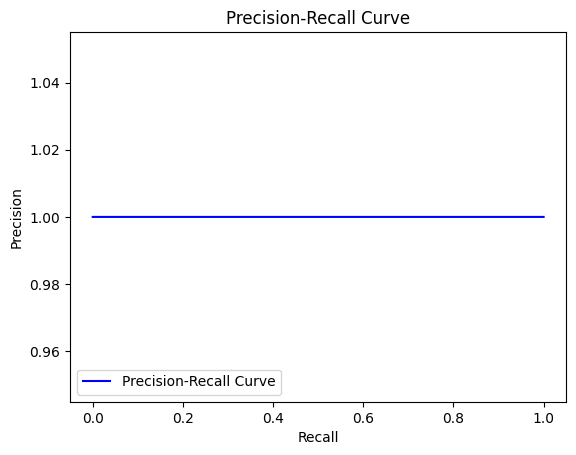

In [255]:
# Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(games_ge_40_test_unique_df.label.to_numpy()
                                                       , games_ge_40_test_unique_df.winner_win_prob.to_numpy())

# Plot Precision-Recall curve
plt.plot(recall, precision, color='blue', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

### since we only have positive labels in our data

# To-Do's

- [ ] The `boxing_matches` dataset isn't quite in the right format. It needs to be the format seen in the `true_skill_wc3_dev.ipynb` notebook. The difference is, that has a `Winner` and `Loser` column. This data hasn't been organized that way, so some work needs to be done there.
- [ ] Once it's in the right format, apply the `TrueSkillThroughTimeApplied` class, in a similar way seen in the `true_skill_wc3_dev` notebook.
- [ ] You'll need to optimize the hyperparameters. You can use the `.learn_optimal_parameters` method for that.
- [ ] Inspect the results. Answer the question.. who is the Greatest Of All Time? FYI, it's OK to trim the results. We don't need to consider all matches since 1911.
- [ ] Read this paper for best practices on how to do this: https://www.herbrich.me/papers/ttt.pdf
- [ ] To make sure we're doing things right, check out this: https://glandfried.github.io/TrueSkillThroughTime.jl/man/examples/. We could run `TrueSkillThroughTimeApplied` on the data given their (there CSV file you can download.) We should be fine, since my code uses the repo developed on that site.
- [ ] Do some sort of out of sample test evaluation. Everything done so far has been in sample. We should hold out some future data and see if this model is good. 